# House Price Prediction: Model 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import mean_squared_log_error


In [2]:
# from google.colab import drive

# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/MyDrive/YData/Kaggle/Housing/train.csv', index_col= 'Id')

# y = df['SalePrice']

In [3]:
df = pd.read_csv('train.csv', index_col= 'Id')
y = df['SalePrice']

In [26]:
df.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorch

To know how to handle the data, we looked at the data description file provided, and categorized each feature to their respective categories:

In [ ]:
obj_nominal      = np.array(['MSSubClass','Street', 'LotConfig','LandContour','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','GarageType','MasVnrType','Foundation','Heating','CentralAir','SaleType','SaleCondition']) 
obj_ordinal      = np.array(['LotShape','Utilities','LandSlope', 'Fence', 'FireplaceQu','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1' ,'BsmtFinType2','HeatingQC','KitchenQual','Functional','GarageFinish','GarageQual','GarageCond','PavedDrive', 'Electrical']) # PoolQC will be converted to boolean. Electrical is ordinal 
# q stands for quantitative
obj_quantitative = np.array(['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt','LotArea','OverallQual','OverallCond','MasVnrArea','BsmtFinSF1','BsmtUnfSF','BsmtFinSF2','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']) # Bigger is "better". Not found 'Bedroom','Kitchen'. Weird feature: 'BsmtFinType2'. High nan rate: 'LotFrontage'
# q_date_related   = np.array(['MoSold','YrSold','YearBuilt','YearRemodAdd','GarageYrBlt']) #For Label encoding

Based on what type of data each feature belongs to will determine how that feature should be engineered: Ordinal Encoding, One-Hot encoding, or leaving as quantitative values

### Handling Null Values

In [4]:
df.columns[df.isna().any().tolist()]

Index(['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence'],
      dtype='object')

Looking at the data description,  a lot of these columns have a significant value of Na (usually means that that the house doesn't have the specificied feature), which are not just missing values. The following list explains how the null values will be handled:


**continuous**: MasVnrArea: mean()
Lot Frontage:  mean()
GarageYrBlt: Mode()


**Categorical** : MasVnrType:  mode()
Electrical : Mode()


**Ordinal_encoding** : 'Leave NA's for the ordinal encoding

'BsmtQual','BsmtCond', 'BsmtExposure','GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'FireplaceQu', 'BsmtFinType1', 'BsmtFinType2',

**One_hot**: Leave NA's for the OneHot Encoding

'GarageType'

In [6]:
#Do the following, only if changing MasVnrType and GarageType NA's to 'None':
def fillNa(df):
    df['LotFrontage'].fillna(0, inplace= True)
    df['MasVnrType'].fillna('None', inplace= True) 

    df.loc[df['MasVnrType'] == 'None', ['MasVnrArea']].fillna(0, inplace= True ) #Use .loc to get rid of the Setting on Slice warning.
    df['MasVnrArea'].fillna(df['MasVnrArea'].mean(), inplace = True)
    
    df.loc[df['GarageType'] == 'None', ['GarageYrBlt']].fillna(0, inplace= True)
    df['GarageYrBlt'].fillna(df['GarageYrBlt'].mode()[0], inplace = True) #Fix this

    # df['Electrical'].fillna(df['Electrical'].mode(), inplace= True)
    df['Electrical'].fillna('Mix', inplace= True) #Maybe switch to mode

    df['MSSubClass'] = df['MSSubClass'].apply(str).fillna('None', inplace= True)
    df["Functional"] = df["Functional"].fillna(df.Functional.mode())
    
    return df

## Feature Engineering/Pre-processing

Preparing the Ordianl Encoding Features: 

In [7]:
def get_ordinal_features(df_tmp, obj_ordinal): #, q_date_related
  df = df_tmp.copy()
  # columns = np.concatenate((obj_ordinal, q_date_related))
  columns = obj_ordinal
  # First encoding type
  enc1_arr = np.array(['ExterQual','ExterCond','PoolQC', 'BsmtQual','BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond'])
  dct1 = {np.nan :0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}

  # Second encoding type
  enc2_arr = np.array(['LotShape'])
  dct2 = {'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4}
  enc3_arr = np.array(['BsmtFinType1', 'BsmtFinType2'])
  dct3 = {np.nan : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6}

  df[enc1_arr] = df[enc1_arr].replace(dct1)
  df[enc2_arr] = df[enc2_arr].replace(dct2)
  df[enc3_arr] = df[enc3_arr].replace(dct3)

  df = df.replace({
                      "BsmtExposure" : {np.nan: 0, 'No' : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                      "Fence" : {np.nan :1, 'MnWw':2, 'GdWo':3, 'MnPrv':4, 'GdPrv':5},
                      "Electrical": {'Mix':1, 'FuseP':2, 'FuseF':3, 'FuseA':4, 'SBrkr':5},
                      	
                      "FireplaceQu" : {np.nan : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                      "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                      "Min2" : 6, "Min1" : 7, "Typ" : 8},
                      # "GarageType"
                      "GarageFinish" : {np.nan: 0, 'Unf': 1, 'RFn': 2, 'Fin': 3 },
                       	
                      "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                      "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                      "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                      "Street" : {"Grvl" : 1, "Pave" : 2},
                      "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}
                    }
                  )
  
  #Date related columns
  # for c in q_date_related: 
  #   lbl = LabelEncoder() 
  #   lbl.fit(list(df[c].values)) 
  #   df[c] = lbl.transform(list(df[c].values))

  return df[columns]

Preparing the Nominal features for One-hot encoding

In [8]:
def get_nominal_features(df, obj_nominal):
  x = df.loc[:, obj_nominal]
  x = x.astype(str) #For some reason, need to convert to string first, otherwise get an unhashable type 'Series' error.

  obj_nominal_oneHot = pd.get_dummies(data=x)
  return obj_nominal_oneHot

Now, merge all of our transformed dataframes back together

In [9]:
def process_df(df):
    filled_df = fillNa(df)
    df_train_ordinal  = get_ordinal_features(filled_df, obj_ordinal) #, q_date_related
    obj_nominal_oneHot = get_nominal_features(filled_df, obj_nominal)
    df_merge = df_train_ordinal.join([df[obj_quantitative], obj_nominal_oneHot]) #, df[q_date_related]
    return df_merge

### Feature Pre-processing Pipeline

This combines all of our pre-processing functions together. The input takes both the training set, and the testing set. We then combine them together to make sure that the transforms of the one_hot encoding are uniform, and return back the pre-processed training and testing data frames (as well as the target labels from the training set).

In [10]:
def feature_pipeline(df_train, df_test):
    
    train_idx = df_train.index
    test_idx = df_test.index
    
    labels = df_train.loc[:, 'SalePrice']
    df_train = df_train.drop('SalePrice', axis = 1)
    df = pd.concat([df_train, df_test])
    
    df_processed = process_df(df)
    
    df_train = df_processed.loc[train_idx]
    
    df_test = df_processed.loc[test_idx]
    return df_train, df_test, labels


In [11]:
##For working with Collab
# train_df = pd.read_csv('train.csv', index_col = 'Id')
# test_df = pd.read_csv('test.csv', index_col= 'Id')

# train_df = pd.read_csv('/content/drive/MyDrive/YData/Kaggle/Housing/train.csv', index_col= 'Id')
# test_df = pd.read_csv('/content/drive/MyDrive/YData/Kaggle/Housing/test.csv', index_col= 'Id')

# df_train, df_test, labels = feature_pipeline(train_df, test_df)

In [12]:
#For working on local IDE
train_df = pd.read_csv('train.csv', index_col = 'Id')
test_df = pd.read_csv('test.csv', index_col= 'Id')

df_train, df_test, labels = feature_pipeline(train_df, test_df)

Double check that there are no null values in the training set:

In [13]:
df_train.columns[df_train.isna().any().tolist()]

Index([], dtype='object')

# Modeling

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error

#### Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor
x_train, x_test, y_train, y_test = train_test_split(df_train.values, labels, test_size= 0.2, random_state= 1) #.values on df_merge just gets rid of the clunky user warning for using a Dataframe

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_log_error

In [17]:
#define your own mse and set greater_is_better=False
mse = make_scorer(mean_squared_error,greater_is_better=False)

paramaters = {'n_estimators': [200,300], #, 300, 500,1000
                'max_depth': [2, 5, 10, 15], #5, 8
                'min_samples_leaf' : [1],
                
                }
clf = GridSearchCV(RandomForestRegressor(), paramaters, n_jobs = -1, cv = 4, scoring = mse)
clf.fit(x_train, y_train)

best_rf = clf.best_estimator_.fit(x_train, y_train)
print(f'validation score with best parameters: {best_rf.score(x_test, y_test)}')
print('mean_squared_log_error', mean_squared_log_error(y_test, best_rf.predict(x_test), squared= False))

print(clf.best_params_)
# rf = RandomForestRegressor(**clf.best_params_)
# rf.fit(x_train, y_train)
# print(f'oob_score on the full training set with: {rf.oob_score_}')


validation score with best parameters: 0.9105248997274333
mean_squared_log_error 0.13913804177539935
{'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 200}


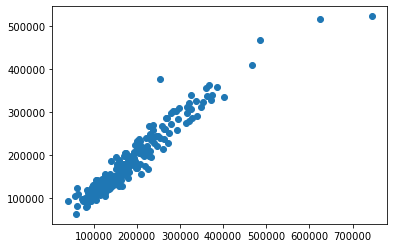

In [18]:
plt.scatter(y_test,best_rf.predict(x_test) )

#### XGBoost

In [19]:
from xgboost.sklearn import XGBRegressor

In [ ]:
# paramaters = {'eta' : [0.3, 0.5, 0.8, 1.1, 1.2],
#                 'n_estimators': np.arange(100,300, step = 50), 
#                 'max_depth': [2, 4, 10, 30, 50, 100], 
#                 }
parameters = {'eta' : [0.05],
                'n_estimators': [400,450,500], 
                'max_depth': [3,4, 5], #pretty much always is 3
                'min_child_weight':  [2,3,4],
                'objective' : ['reg:gamma'],
                'colsample_bytree': [0.3,0.4, 0.5]
                }

XGB_clf = GridSearchCV(XGBRegressor(),  parameters, cv = 5, verbose= 1)
XGB_clf.fit(x_train, y_train)
print(XGB_clf.best_params_)

XG = XGBRegressor(**XGB_clf.best_params_)
XG.fit(x_train, y_train)
print(f'validation score with best parameters: {XG.score(x_test, y_test)}')
print('mean_squared_log_error', mean_squared_log_error(y_test, XG.predict(x_test), squared= False))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
{'colsample_bytree': 0.4, 'eta': 0.05, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 450, 'objective': 'reg:gamma'}
validation score with best parameters: 0.9160217600701733
mean_squared_log_error 0.12478733604217326

In [20]:
from xgboost.sklearn import XGBRegressor
XGB_clf = XGBRegressor(colsample_bytree= 0.4, eta = 0.05, max_depth=3, min_child_weight=2 , n_estimators=450, objective='reg:gamma')
XGB_clf.fit(x_train, y_train)

print(f'validation score with best parameters: {XGB_clf.score(x_test, y_test)}')
print('mean_squared_log_error', mean_squared_log_error(y_test, XGB_clf.predict(x_test), squared= False))

validation score with best parameters: 0.9215591136461252
mean_squared_log_error 0.1230038455970388


Mean squared error: 559435959.880
Coefficient of determination: 0.922


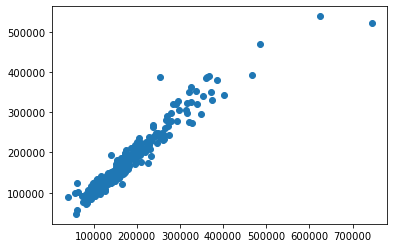

In [21]:
from sklearn.metrics import r2_score
y_test_pred = XGB_clf.predict(x_test)
plt.scatter(y_test, y_test_pred)

# The coefficients
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_test,y_test_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.3f" % r2_score(y_test,y_test_pred))

# Submission

In [ ]:
# test_df = pd.read_csv('/content/drive/MyDrive/YData/Kaggle/Housing/test.csv')
# y_test_sub = XGB_clf.predict(df_test.values)
# df_for_submission = test_df[['Id']]
# df_for_submission['Predicted'] = y_test_sub
# df_for_submission.set_index('Id').Predicted.to_csv('/content/drive/MyDrive/YData/Kaggle/Housing/tal_result_example4.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [25]:
test_df = pd.read_csv('test.csv')
y_test_sub = XGB_clf.predict(df_test.values)
df_for_submission = test_df.loc[:, ['Id']]
df_for_submission['Predicted'] = y_test_sub
df_for_submission.set_index('Id').Predicted.to_csv('XGBoost_submission.csv')